In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pylab as plt
from numpy import array as arr

In [2]:
def CreateCamera( R, T, f, C ):

  #  SINTESI DI UNA CAMERA  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  # R: matrice di rotazione [3x3]
  # T: vettore traslazione [3x1]
  # f: lunghezza focale (in pixel)
  # C: posizione del centro ottico [cx,cy]

  # A partire da R e T costruisco la matrice Estrinseca E

  E = np.zeros((4,4))
  E[0:3,0:3] = R #Rotazione
  E[0:3,3] = T #Traslazione
  E[3,3] = 1 #coord omogenee
  
  # Costruisco la matrice di calibrazione intrinseca K
  K = arr([[f, 0, C[0], 0], [0, f, C[1], 0], [0, 0, 1, 0]])

  # Costruisco la matrice di proiezione M, prodotto di K ed E
  M = np.dot(K,E)
  return M


In [3]:
def CameraProj(M, Pw, ImSize):
  #  Proiezione prospettica di CAMERA   

  # M: matrice di proiezione della camera [3x4]
  # Pw: punti di scena, in coordinate world [Nx3]

  # Mediante la matrice M, proietto i punti di scena P
  # Passo in coordinate omogenee (che chiamo P_tilde e p_im_tilde)

  N = Pw.shape[0]              # N: numero di punti di scena
  # punti di scena in coordinate omogenee
  P_tilde = np.ones((4,N)) 
  P_tilde[0:3, :] = Pw.T
  p_im_tilde = np.dot(M,  P_tilde)       # proietto

  p_im = [[p_im_tilde[0,:]/p_im_tilde[2,:]] ,  [p_im_tilde[1,:]/p_im_tilde[2,:]]] # coordinate immagine euclidee

  # genero l'immagine degli N punti e
  # traccio anche il rettangolo che rappresenta il campo visivo della camera
  p_im = np.squeeze(p_im) 
  fig = plt.figure()
  ax = fig.add_subplot(111 )
  ax.scatter(p_im[0,:], p_im[1,:], marker='o')
  for id in range(N-1):
    ax.plot(*make_line(p_im[:, id], p_im[:,id+1]), color="blue", alpha=0.25)

  return p_im

In [4]:
#Costruisco un modello di scena (21 punti)

facciata1 = arr([[0, 2, 0], [0, 0, 0] ,[2, 0, 0], [2, 2, 0], [0, 2, 0], [1, 3, 0], [2, 2, 0]])
facciata2 = arr([[0, 2, 1], [0, 0, 1] ,[2, 0, 1], [2, 2, 1], [0, 2, 1], [1, 3, 1], [2, 2, 1]])
facciata3 = arr([[0, 2, 3], [0, 0, 3] ,[2, 0, 3], [2, 2, 3], [0, 2, 3], [1, 3, 3], [2, 2, 3]])
casa = np.vstack((facciata1,facciata2,facciata3))
N = casa.shape[0]


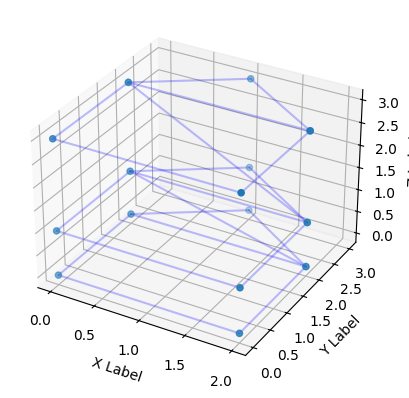

In [5]:
# Vediamo i punti nel loro spazio di scena
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(casa[:,0], casa[:,1], casa[:,2], marker='o')

make_line = lambda u, v: np.vstack((u, v)).T

for id in range(N-1):
  ax.plot(*make_line(casa[id,:], casa[id+1,:]), color="blue", alpha=0.25)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [6]:
#Creo due camere che osservano la scena: CAMERA 1: di fronte, stesso asse Z (Rotazione nulla), distanza Z=10
R1 = np.identity(3)   # Rotazione
T1 =  arr([0, 0 , 10]) # Traslazione

In [7]:
#Genero i punti immagine con la funzione CreateCamera:
f1 = 2000
C1 = np.array([500, 500])
M1 = CreateCamera(R1, T1, f1, C1)

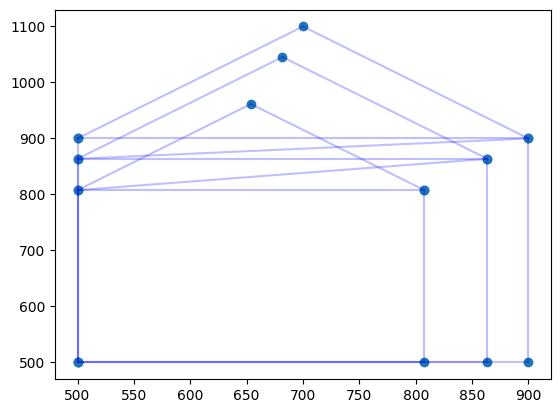

In [8]:
p_im1 = arr(CameraProj(M1, casa, np.array([1000, 1000]))) 

In [9]:
# CAMERA 2: lontana come camera 1 (Z=10) e poi GIRATA DI 45º su asse Y
theta = np.radians(45)
c, s = np.cos(theta), np.sin(theta)
R2 =  np.array([[c, 0, s],
                [0, 1, 0],
                [-s, 0, c]])
T2 = arr([ 0, 0 , 10]) #Traslazione


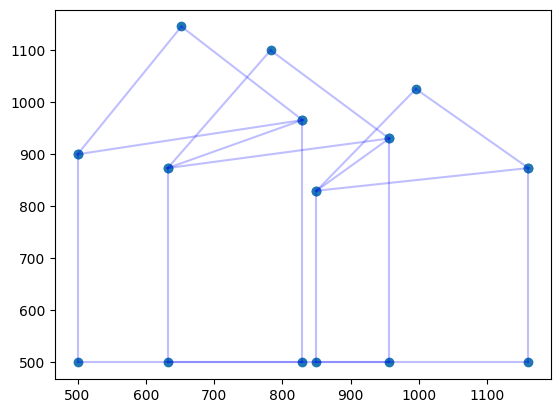

In [10]:
#Genero i punti immagine con la funzione CreateCamera:
f2= 2000
C2= np.array([500, 500])
M2 = CreateCamera(R2, T2, f2,C2)

p_im2 = CameraProj(M2, casa, np.array([1000, 1000])) 

In [11]:
# Calcolo la matrice essenziale:  
R = np.dot(R1 , R2.T)        # rotazione necessaria per portare il sistema di coordinate della camera2
                             # in quello della camera1.
T = T1 - np.dot(R, T2.reshape(3))     # Traslazione da O1 a O2 (Baseline)

In [12]:
Tx = arr(((0, -T[2],  T[1]), (T[2] ,0, -T[0]), (-T[1], T[0], 0)))    # T skew-symmetric

E = np.dot(Tx, R) # Matrice ESSENZIALE
 

In [13]:
# Verifico il vincolo essenziale *********************
# Calcolo le coordinate immagine normalizzate (f=1)
pcam1 = np.dot(R1, casa.T) + T1.reshape(3,1)    # Camera 1
pnorm1 = np.vstack((pcam1[0,:]/pcam1[2,:], pcam1[1,:]/pcam1[2,:] , np.expand_dims(np.ones(N), axis=0)))

pcam2 = np.dot(R2, casa.T) + T2.reshape(3,1)   # Camera 2
pnorm2 = np.vstack((pcam2[0,:]/pcam2[2,:], pcam2[1,:]/pcam2[2,:], np.expand_dims(np.ones(N), axis=0)))  

In [14]:
# Verifico il vincolo epipolare: p1'*E*p2 = 0
print('Verifica del vincolo epipolare: \n' )
for i in range(N):
  res = np.dot(np.dot(np.transpose(pnorm1[:,i]), E),  pnorm2[:,i])
  print(i, res.astype(int))


Verifica del vincolo epipolare: 

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0


In [15]:
###### Calcolo MATRICE FONDAMENTALE
# Costruisco le matrici di calibrazione intrinseca K
 
K1 = arr([[f1, 0, C1[0]],[0, f1, C1[1]],[0, 0, 1]])     # Camera 1 having (f1,C1) as intrinsic parameters
K2 = arr([[f2, 0, C2[0]],[0, f2, C2[1]],[0, 0, 1]])     # Camera 2 having (f2,C2) as intrinsic parameters

F = (np.linalg.inv(K1)).T * E * np.linalg.inv(K2)

In [16]:
p_im1_tilde = np.ones ((3,N))
p_im1_tilde[0:2,:] = p_im1

p_im2_tilde = np.ones ((3,N))
p_im2_tilde[0:2,:] = p_im2

In [17]:
#Verifico il vincolo fondamentale: pim1' * F * pim2 = 0

print('Verifica del vincolo fondamentale:')
 
for i in range(N):
  res = np.dot(np.dot(np.transpose(p_im1_tilde[:,i]), F),  p_im2_tilde[:,i])
  print(i, res.astype(int))

Verifica del vincolo fondamentale:
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
